# AlexNet

In [2]:
import torch
from torch import nn


my_Alexnet = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Flatten(),
    
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), 
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), 
    nn.ReLU(),
    nn.Dropout(p=0.5),
    
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [3]:
# 查看每一层
x = torch.rand(1, 1, 28, 28)
for layer in my_Alexnet:
    x = layer(x)
    print(layer.__class__.__name__, 'output shape:\t', x.shape)

Conv2d output shape:	 torch.Size([1, 96, 5, 5])
ReLU output shape:	 torch.Size([1, 96, 5, 5])
MaxPool2d output shape:	 torch.Size([1, 96, 2, 2])
Conv2d output shape:	 torch.Size([1, 256, 2, 2])
ReLU output shape:	 torch.Size([1, 256, 2, 2])


RuntimeError: Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small

In [4]:
import torchvision


# 加载Fashion-MNIST数据集
def loadFashion(root, trans, batch_size, resize=None, download=False):
    if resize:
        trans.insert(0, torchvision.transforms.Resize(size=resize))

    train_dataset = torchvision.datasets.FashionMNIST(root=root, train=True, transform=trans, download=download)
    test_dataset = torchvision.datasets.FashionMNIST(root=root, train=False, transform=trans, download=download)

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_iter, test_iter

In [5]:
train_iter, test_iter = loadFashion(root="../../Data/FashionMNIST", trans=torchvision.transforms.ToTensor(), batch_size=128, download=False)

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([1

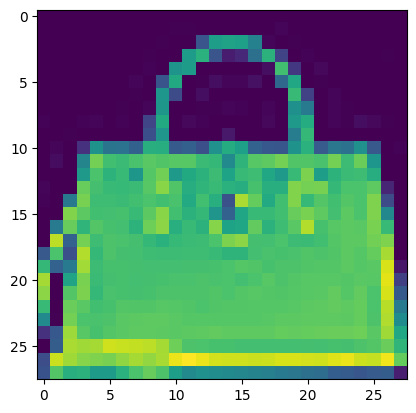

In [6]:
# 查看dataiter中的数据
import matplotlib.pyplot as plt


for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    for x in X:
        plt.imshow(x.squeeze().numpy())
        break

In [7]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval()
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            # 改回训练模式
            net.train()

            n += y.shape[0]
    return acc_sum / n


In [8]:
def train(net, train_iter, test_iter, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            print(y_hat.shape, y.shape)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net, device)
        print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f" % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc))

In [9]:
net = my_Alexnet

train_iter, test_iter = loadFashion(root="../../Data/FashionMNIST", trans=torchvision.transforms.ToTensor(), batch_size=128, download=False)

lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10

train(net, train_iter, test_iter, optimizer, device, num_epochs)

training on cuda


RuntimeError: Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small